In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


In [6]:
#Can be done using one for loop
import zipfile

with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train.zip") as z:
    z.extractall(".")
with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train_masks.zip") as z:
    z.extractall(".")
with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip") as z:
    z.extractall(".")

In [11]:
import os
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transform

In [10]:
len(os.listdir('/kaggle/working/train'))

5088

In [19]:
%config Completer.use_jedi = False

4fc2470c0f7b_10.jpg


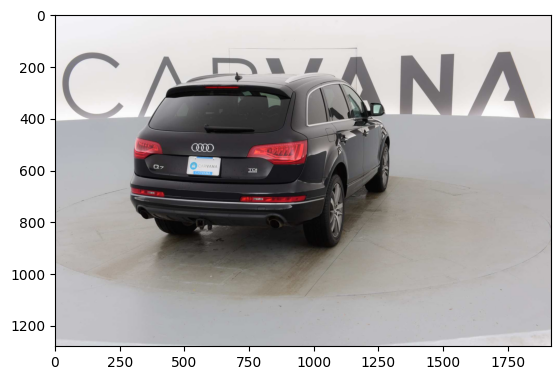

In [24]:
for i in os.listdir('/kaggle/working/train'):
    image = os.path.join('/kaggle/working/train',i)
    im = cv2.imread(image)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    plt.imshow(im)

    print(i)
    break

TypeError: Image data of dtype <U52 cannot be converted to float

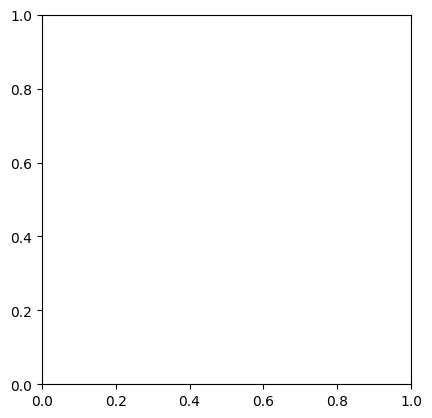

In [30]:
file = '/kaggle/working/train_masks/4fc2470c0f7b_10_mask.gif'
msk = np.array(file)
plt.imshow(msk)

In [26]:
#Need to get the mask for the image above
for i in os.listdir('/kaggle/working/train_masks'):
    print(i)
    break
    

4dc8a7fe7c02_11_mask.gif


In [21]:
df = pd.read_csv('/kaggle/working/train_masks.csv')

In [22]:
df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...
